In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/donorschoose/Donations.csv
/kaggle/input/donorschoose/Schools.csv
/kaggle/input/donorschoose/Teachers.csv
/kaggle/input/donorschoose/Donors.csv
/kaggle/input/donorschoose/Projects.csv
/kaggle/input/donorschoose/Resources.csv


In [2]:
import pandas as pd
import os

# Définir le chemin vers le dossier
base_path = r"/kaggle/input/donorschoose/"

# Charger les données disponibles (sans la colonne manquante)
donations = pd.read_csv(
    os.path.join(base_path, "Donations.csv"),
    usecols=["Donor ID", "Project ID", "Donation Amount"]
)

donors = pd.read_csv(
    os.path.join(base_path, "Donors.csv"),
    usecols=["Donor ID", "Donor City", "Donor State", "Donor Is Teacher"]
)

projects = pd.read_csv(
    os.path.join(base_path, "Projects.csv"),
    usecols=[
        "Project ID", "School ID", "Teacher ID", "Project Posted Date",
        "Project Subject Category Tree", "Project Grade Level Category",
        "Project Resource Category", "Project Cost"
    ]
)

teachers = pd.read_csv(
    os.path.join(base_path, "Teachers.csv"),
    usecols=["Teacher ID", "Teacher Prefix"]
)

schools = pd.read_csv(
    os.path.join(base_path, "Schools.csv"),
    usecols=["School ID", "School City", "School State", "School Metro Type"]
)

# Fusion
df = donations.merge(donors, on='Donor ID', how='left')
df = df.merge(projects, on='Project ID', how='left')
df = df.merge(teachers, on='Teacher ID', how='left')
df = df.merge(schools, on='School ID', how='left')

# Aperçu du DataFrame fusionné
print(df.head())


                         Project ID                          Donor ID  \
0  000009891526c0ade7180f8423792063  6d5b22d39e68c656071a842732c63a0c   
1  000009891526c0ade7180f8423792063  377944ad61f72d800b25ec1862aec363   
2  000009891526c0ade7180f8423792063  4aaab6d244bf3599682239ed5591af8a   
3  000009891526c0ade7180f8423792063  0b0765dc9c759adc48a07688ba25e94e   
4  000009891526c0ade7180f8423792063  1f4b5b6e68445c6c4a0509b3aca93f38   

   Donation Amount      Donor City Donor State Donor Is Teacher  \
0            25.00  Salt Lake City        Utah              Yes   
1            25.00         Phoenix     Arizona               No   
2            25.00        Riverton        Utah              Yes   
3            20.00        Riverton        Utah               No   
4           178.37     West Jordan        Utah               No   

                          School ID                        Teacher ID  \
0  5aa86a53f658c198fd4e42c541411c76  6d5b22d39e68c656071a842732c63a0c   
1  5aa86a53f

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Load dataset (update path to your actual file)

# 1. Data Cleaning
def clean_data(df):
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Remove rows with missing key values
    df = df.dropna(subset=['Donor ID', 'Donation Amount', 'Project Posted Date'])
    
    # Clean donation amounts
    df['Donation Amount'] = df['Donation Amount'].replace('[\$,]', '', regex=True).astype(float)
    
    # Convert dates
    df['Project Posted Date'] = pd.to_datetime(df['Project Posted Date'], errors='coerce')
    
    # Standardize categoricals
    df['Donor Is Teacher'] = df['Donor Is Teacher'].str.strip().str.title()
    df['Teacher Prefix'] = df['Teacher Prefix'].str.strip().str.replace('.', '')
    
    # Remove unnecessary columns
    cols_to_drop = ['Project ID', 'Donor City', 'School City', 'Teacher Prefix']
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    return df

cleaned_df = clean_data(df)

In [4]:
# 2. Feature Engineering
def engineer_features(df):
    # Sort by donor and date
    df = df.sort_values(['Donor ID', 'Project Posted Date'])

    # Create reference date (1 day after last donation)
    reference_date = df['Project Posted Date'].max() + pd.Timedelta(days=1)

    # Donor-level features
    donor_features = df.groupby('Donor ID').agg(
        total_donations=('Donation Amount', 'count'),
        total_donated=('Donation Amount', 'sum'),
        first_donation_date=('Project Posted Date', 'min'),
        last_donation_date=('Project Posted Date', 'max'),
        unique_teachers=('Teacher ID', 'nunique'),
        unique_subjects=('Project Subject Category Tree', 'nunique'),
        unique_schools=('School ID', 'nunique')
    ).reset_index()

    # Calculate derived features
    donor_features['avg_donation'] = donor_features['total_donated'] / donor_features['total_donations']
    donor_features['donation_frequency'] = donor_features['total_donations'] / (
        (donor_features['last_donation_date'] - donor_features['first_donation_date']).dt.days / 30
    )
    donor_features['days_since_first_donation'] = (reference_date - donor_features['first_donation_date']).dt.days
    donor_features['days_since_last_donation'] = (reference_date - donor_features['last_donation_date']).dt.days
    donor_features['donor_tenure'] = (donor_features['last_donation_date'] - donor_features['first_donation_date']).dt.days

    # Merge donor features back to main dataframe
    df = df.merge(donor_features, on='Donor ID', how='left')

    # Current donation features
    df['donor_is_teacher_binary'] = df['Donor Is Teacher'].map({'Yes': 1, 'No': 0})

    # Time-based features
    df['donation_day_of_week'] = df['Project Posted Date'].dt.dayofweek
    df['donation_month'] = df['Project Posted Date'].dt.month
    df['donation_quarter'] = df['Project Posted Date'].dt.quarter

    # Project cost handling with robust conversion
    if 'Project Cost' in df.columns:
        # Convert to string and clean the column
        df['Project Cost'] = df['Project Cost'].astype(str).replace('[\$,]', '', regex=True)

        # Convert to numeric, coerce errors to NaN
        df['Project Cost'] = pd.to_numeric(df['Project Cost'], errors='coerce')

        # Optionally filter out rows with invalid project costs (you can remove this if you prefer to impute)
        df = df[df['Project Cost'].notna() & (df['Project Cost'] > 0)]

        # Compute amount_vs_project_cost
        df['amount_vs_project_cost'] = df['Donation Amount'] / df['Project Cost']

    # Create donation sequence numbers
    df['donation_sequence'] = df.groupby('Donor ID').cumcount() + 1

    # Calculate days since previous donation
    df['days_since_prev_donation'] = df.groupby('Donor ID')['Project Posted Date'].diff().dt.days
    df['days_since_prev_donation'] = df['days_since_prev_donation'].fillna(0)

    return df

# Apply the function to your cleaned dataframe
engineered_df = engineer_features(cleaned_df)


In [ ]:
engineered_df

In [6]:
# ========== PART 1: PREPROCESSING & FEATURE ENGINEERING ==========
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

time_series_df = engineered_df
# Create directory for models
os.makedirs('time_series_models', exist_ok=True)

def prepare_time_series_data(df):
    """Prepare time series data for donation prediction"""
    # Convert to datetime features
    df['donation_date'] = pd.to_datetime(df['days_since_first_donation'], origin='unix', unit='D')
    
    # Sort by donor and date
    df = df.sort_values(['Donor ID', 'donation_date'])
    
    # Create time-based features
    df['day_of_week'] = df['donation_date'].dt.dayofweek
    df['day_of_month'] = df['donation_date'].dt.day
    df['month'] = df['donation_date'].dt.month
    df['quarter'] = df['donation_date'].dt.quarter
    
    # Calculate time since last donation
    df['days_since_last'] = df.groupby('Donor ID')['days_since_first_donation'].diff().fillna(0)
    
    # Create target variable: days until next donation
    df['days_until_next'] = df.groupby('Donor ID')['days_since_first_donation'].shift(-1) - df['days_since_first_donation']
    df['days_until_next'] = df['days_until_next'].fillna(df['days_until_next'].median())
    
    # Filter relevant features
    features = [
        'Donation Amount', 'donor_tenure', 'donation_sequence',
        'days_since_prev_donation', 'day_of_week', 'day_of_month',
        'month', 'quarter', 'amount_vs_project_cost'
    ]
    
    return df[['Donor ID', 'donation_date', 'days_until_next'] + features]

def create_donor_features(df):
    """Create donor-level features for time series modeling"""
    # Group by donor
    grouped = df.groupby('Donor ID')
    
    # Create sequences
    sequences = []
    targets = []
    donor_ids = []
    
    for donor_id, group in tqdm(grouped, desc="Processing donors"):
        if len(group) < 3:  # Skip donors with less than 3 donations
            continue
            
        # Sort by date
        group = group.sort_values('donation_date')
        
        # Create sequences of 3 donations to predict the 4th
        for i in range(len(group) - 3):
            seq = group.iloc[i:i+3]
            target = group.iloc[i+3]['days_until_next']
            
            # Extract features
            seq_features = seq[['Donation Amount', 'donor_tenure', 'donation_sequence',
                               'days_since_prev_donation', 'day_of_week', 'day_of_month',
                               'month', 'quarter', 'amount_vs_project_cost']].values
            
            sequences.append(seq_features)
            targets.append(target)
            donor_ids.append(donor_id)
    
    return np.array(sequences), np.array(targets), donor_ids

# Load and prepare data
df = time_series_df.copy()
df = prepare_time_series_data(df)

# Create sequences and targets
X_sequences, y_targets, donor_ids = create_donor_features(df)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_targets, test_size=0.2, random_state=42
)

# Save processed data
np.save('time_series_models/X_train.npy', X_train)
np.save('time_series_models/X_test.npy', X_test)
np.save('time_series_models/y_train.npy', y_train)
np.save('time_series_models/y_test.npy', y_test)

print("Preprocessing complete! Data saved.")
print(f"Training sequences: {X_train.shape}, Test sequences: {X_test.shape}")

Processing donors: 100%|██████████| 1741748/1741748 [18:34<00:00, 1562.52it/s] 


Preprocessing complete! Data saved.
Training sequences: (993619, 3, 9), Test sequences: (248405, 3, 9)


In [11]:
df

,Donor ID,donation_date,days_until_next,Donation Amount,donor_tenure,donation_sequence,days_since_prev_donation,day_of_week,day_of_month,month,quarter,amount_vs_project_cost
0,00000ce845c00cbf0686c992fc369df4,1974-05-19,0.0,50.00,0.0,1,0.0,6.0,19.0,5.0,2.0,0.025316
1,00002783bc5d108510f3f9666c8b1edd,1972-04-22,0.0,99.00,0.0,1,0.0,5.0,22.0,4.0,2.0,0.067428
2,00002d44003ed46b066607c5455a999a,1971-08-09,0.0,13.75,381.0,1,0.0,0.0,9.0,8.0,3.0,0.037198
3,00002d44003ed46b066607c5455a999a,1971-08-09,0.0,9.69,381.0,2,5.0,0.0,9.0,8.0,3.0,0.018881
4,00002d44003ed46b066607c5455a999a,1971-08-09,0.0,10.00,381.0,3,24.0,0.0,9.0,8.0,3.0,0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...
3890877,ffffad3f78f2b13ce571c709dd049cd3,1973-06-14,0.0,25.00,305.0,1,0.0,3.0,14.0,6.0,2.0,0.012821
3890878,ffffad3f78f2b13ce571c709dd049cd3,1973-06-14,0.0,100.00,305.0,2,305.0,3.0,14.0,6.0,2.0,0.105832
3890879,ffffb67dc0b1f2c2d93231f0ccf81166,1971-03-27,0.0,25.00,0.0,1,0.0,5.0,27.0,3.0,1.0,0.046765
3890880,ffffc2e1225ac40a3ace9b8562115c9b,1971-09-12,0.0,75.00,0.0,1,0.0,6.0,12.0,9.0,3.0,0.220757



Building LSTM Model...
Training LSTM Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 242s 18ms/step - loss: 2.9138e-06 - mae: 2.5083e-04 - val_loss: 8.8182e-14 - val_mae: 2.5277e-07
Epoch 2/20
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 227s 18ms/step - loss: 7.3897e-10 - mae: 1.5202e-05 - val_loss: 2.5301e-16 - val_mae: 1.2815e-08
Epoch 3/20
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 229s 18ms/step - loss: 7.1610e-10 - mae: 1.3641e-05 - val_loss: 2.7535e-11 - val_mae: 5.2472e-06
Epoch 4/20
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 239s 19ms/step - loss: 7.0929e-10 - mae: 1.3035e-05 - val_loss: 5.9432e-13 - val_mae: 7.7091e-07
Epoch 5/20
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 232s 19ms/step - loss: 7.1385e-10 - mae: 1.3269e-05 - val_loss: 1.6672e-11 - val_mae: 4.0830e-06
Epoch 6/20
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 230s 19ms/step - loss: 7.3149e-10 - mae: 1.4104e-05 - val_loss: 2.6021e-09 - val_mae: 5.1011e-05
Epoch 7/20
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 232s 19ms/step - loss: 6.9599e-10 - mae: 1.3299e-05 - val_loss: 5.4885e-11 - val_mae: 7.4084e-06
Epoch 8/20
12

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Calculating feature importance...
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step
7763/7763 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step


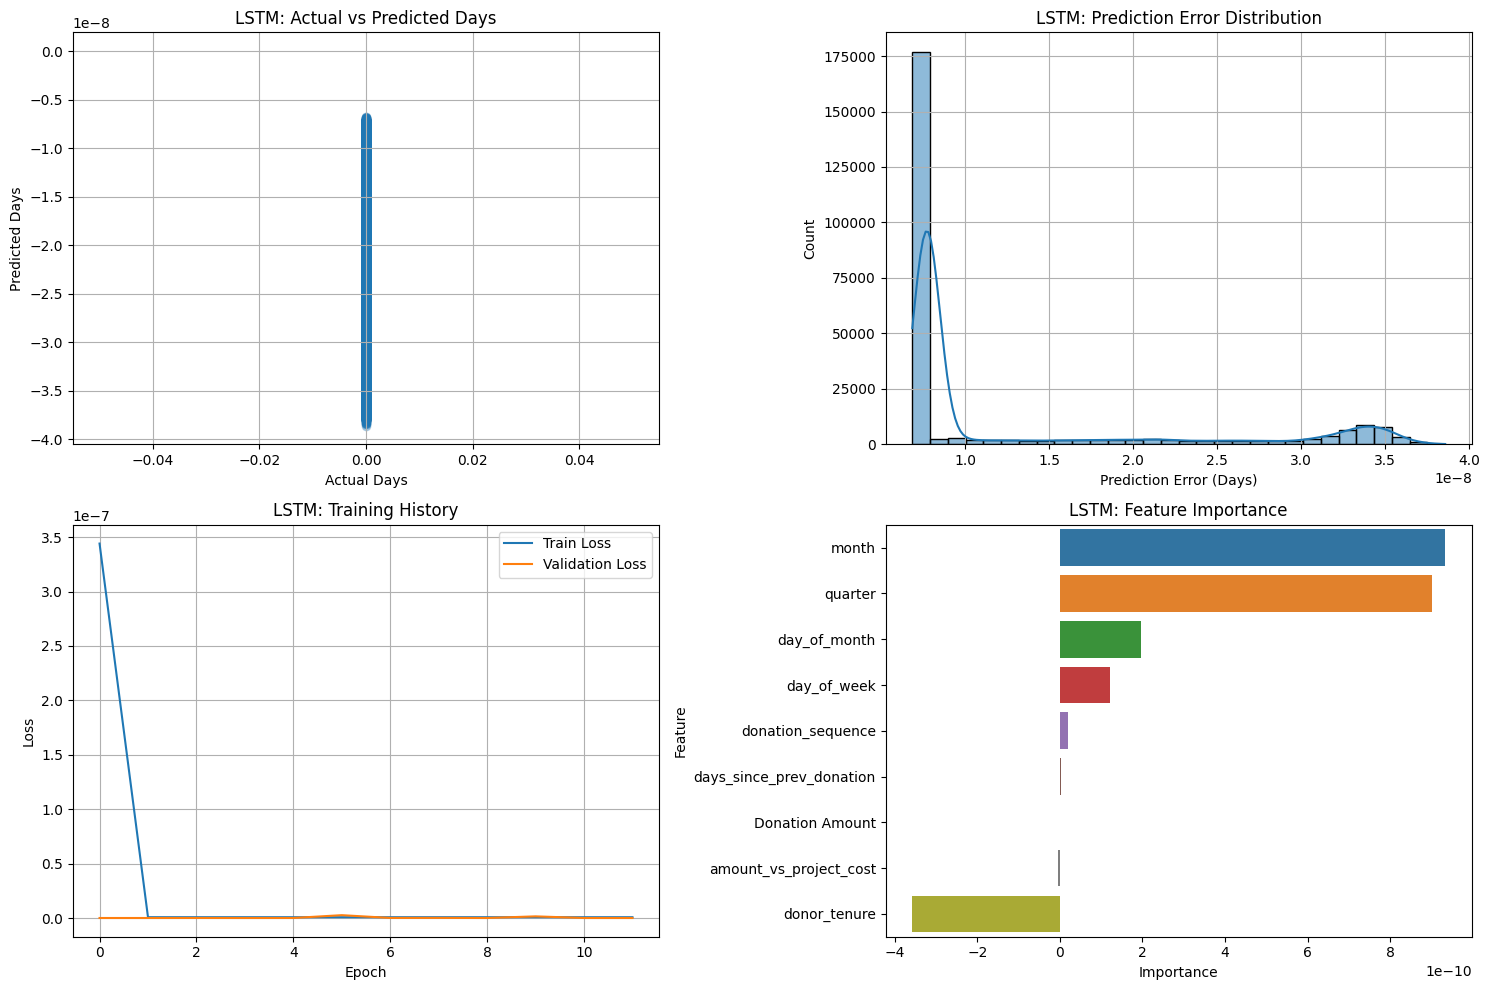

In [8]:
# ========== PART 2: LSTM MODEL ==========
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load processed data
X_train = np.load('time_series_models/X_train.npy')
X_test = np.load('time_series_models/X_test.npy')
y_train = np.load('time_series_models/y_train.npy')
y_test = np.load('time_series_models/y_test.npy')

# Reshape for LSTM (samples, timesteps, features)
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

# Scale data
sequence_scaler = MinMaxScaler()
X_train_lstm = sequence_scaler.fit_transform(X_train.reshape(-1, n_features))
X_train_lstm = X_train_lstm.reshape(-1, n_timesteps, n_features)

X_test_lstm = sequence_scaler.transform(X_test.reshape(-1, n_features))
X_test_lstm = X_test_lstm.reshape(-1, n_timesteps, n_features)

# Build LSTM model
print("\nBuilding LSTM Model...")
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features))),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training LSTM Model...")
history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Save model
lstm_model.save('time_series_models/lstm_model.keras')
joblib.dump(sequence_scaler, 'time_series_models/lstm_scaler.joblib')
print("LSTM model saved!")

# Evaluate
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM Performance: MAE={mae_lstm:.2f}, RMSE={rmse_lstm:.2f}, R²={r2_lstm:.2f}")

# Visualizations
plt.figure(figsize=(15, 10))

# Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_lstm, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('LSTM: Actual vs Predicted Days')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.grid(True)

# Error distribution
residuals = y_test - y_pred_lstm
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.title('LSTM: Prediction Error Distribution')
plt.xlabel('Prediction Error (Days)')
plt.grid(True)

# Training history
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Feature importance (using permutation)
print("Calculating feature importance...")
def calculate_permutation_importance(model, X, y, feature_names):
    baseline = mean_absolute_error(y, model.predict(X).flatten())
    importances = []
    
    for i in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, i])
        permuted_score = mean_absolute_error(y, model.predict(X_permuted).flatten())
        importances.append(baseline - permuted_score)
    
    return importances

feature_names = [
    'Donation Amount', 'donor_tenure', 'donation_sequence',
    'days_since_prev_donation', 'day_of_week', 'day_of_month',
    'month', 'quarter', 'amount_vs_project_cost'
]

lstm_importances = calculate_permutation_importance(
    lstm_model, X_test_lstm, y_test, feature_names
)

plt.subplot(2, 2, 4)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lstm_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('LSTM: Feature Importance')
plt.tight_layout()
plt.savefig('time_series_models/lstm_evaluation.png')
plt.show()

In [12]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# === Load the trained LSTM model and scaler ===
model = load_model('time_series_models/lstm_model.keras')
scaler = joblib.load('time_series_models/lstm_scaler.joblib')

# === Load the same test set you used during training ===
X_test = np.load('time_series_models/X_test.npy')
y_test = np.load('time_series_models/y_test.npy')

# === Get the LSTM input shape ===
n_timesteps, n_features = X_test.shape[1], X_test.shape[2]

# === Prepare a real sample from test set (as example) ===
sample_index = 0  # You can change this index to test other samples
real_sample = X_test[sample_index:sample_index+1]  # shape (1, timesteps, features)

# === Scale the sample using the same scaler ===
real_sample_scaled = scaler.transform(real_sample.reshape(-1, n_features))
real_sample_scaled = real_sample_scaled.reshape(1, n_timesteps, n_features)

# === Predict ===
prediction = model.predict(real_sample_scaled)
predicted_days = prediction.flatten()[0]

print(f"\n🧠 Predicted number of days until next donation for sample {sample_index}: {predicted_days:.2f} days")
print(f"📊 Actual number of days for this sample: {y_test[sample_index]:.2f} days")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

🧠 Predicted number of days until next donation for sample 0: -0.00 days
📊 Actual number of days for this sample: 0.00 days


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import pandas as pd

# Load processed data
X_train = np.load('time_series_models/X_train.npy')
X_test = np.load('time_series_models/X_test.npy')
y_train = np.load('time_series_models/y_train.npy')
y_test = np.load('time_series_models/y_test.npy')

n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

# Scale features using MinMaxScaler (fit on train, transform on train and test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)

print("\nBuilding improved LSTM model...")

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_timesteps, n_features)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1),
    Activation('relu')  # This forces output >= 0, no negative predictions
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(),  # Robust to outliers, better than MSE sometimes
    metrics=['mae']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

print("Training model...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Save model and scaler
model.save('time_series_models/lstm_model_improved.keras')
joblib.dump(scaler, 'time_series_models/lstm_scaler_improved.joblib')
print("Model and scaler saved!")

# Predict and clip to 0+ just in case
y_pred = model.predict(X_test_scaled).flatten()
y_pred = np.clip(y_pred, 0, None)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Improved LSTM Performance: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")

# Visualization
plt.figure(figsize=(15, 10))

# Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.title('Actual vs Predicted Days')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.grid(True)

# Residuals distribution
residuals = y_test - y_pred
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Prediction Error Distribution')
plt.xlabel('Error (Days)')
plt.grid(True)

# Training loss history
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Feature importance (Permutation Importance)
print("Calculating feature importance...")
def calculate_permutation_importance(model, X, y, feature_names):
    baseline = mean_absolute_error(y, model.predict(X).flatten())
    importances = []

    for i in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, i])
        permuted_score = mean_absolute_error(y, model.predict(X_permuted).flatten())
        importances.append(baseline - permuted_score)

    return importances

feature_names = [
    'Donation Amount', 'donor_tenure', 'donation_sequence',
    'days_since_prev_donation', 'day_of_week', 'day_of_month',
    'month', 'quarter', 'amount_vs_project_cost'
]

importances = calculate_permutation_importance(model, X_test_scaled, y_test, feature_names)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.subplot(2, 2, 4)
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Permutation)')
plt.tight_layout()
plt.savefig('time_series_models/lstm_evaluation_improved.png')
plt.show()



Building improved LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 3, 256)              │         141,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,033 (1.21 MB)

 Trainable params: 316,033 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/30
12421/12421 ━━━━━━━━━━━━━━━━━━━━ 242s 18ms/step - loss: 1.4995e-07 - mae: 1.3004e-05 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
  257/12421 ━━━━━━━━━━━━━━━━━━━━ 3:17 16ms/step - loss: 0.0000e+00 - mae: 0.0000e+00